In [38]:
# import all needed libraries 
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from glob import glob
import networkx as nx
import os 
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# load and preprocess the data

indir = "/home/hillerton/projects/algorithm_course/NBN_FC_finder/data/1490010574990_17"
pattern = "GSM"

# check to make sure that the given directory exists 
if not os.path.isdir(indir):
    raise ValueError(indir,"does not apear to be a direcotry")

find = "*"+pattern+"*.txt"
    
# initialize a value that tracks what column the data should be added to     
col = 2
    
# if the directory exists find and merge all files contaning a wanted patern 
for i in glob(indir+"/"+find):
    fil = pd.read_csv(i,sep="\t",header=None)
    if not 'data' in locals():
        data = pd.DataFrame(fil.iloc[:,1]) 
    else:
        data[col] = fil.iloc[:,1]
        col+=1  
      

In [14]:
# as the micro array data is fairy raw it is here
# assigned to a gene locus ID (used by the true network)
# and then all spots for the same locus is merged down through mean

annotation_file = "GPL16048-tbl-1.txt"

# first step is to load the file contaning this infomration 
gene_annotation = pd.read_csv(indir+"/"+annotation_file,sep="\t" ,header=None)
print(gene_annotation.shape)
# start by removing rows that are simply posetive and negative controls 
genes = gene_annotation[~gene_annotation.iloc[:,5].str.contains("pos")]
genes = genes[~genes.iloc[:,5].str.contains("neg")]

# then to get the names used in the gold standard turn col 9 to str 
genes.iloc[:,9] = genes.iloc[:,9].apply(str)
# then use regular expression to find the local name using the pattern of these names 
# OBS due to the nature of these patterns being very different this will most likey need to 
# be changed for other species and is thus sub optimal here. 

genes[[9]] = genes.iloc[:,9].str.extract(r'(b.*?(?=\|))')


# then get a list only with the row id (used in the raw data) and the spot ID to merge on
# make sure to use copy so that the original dataframe is not affected with changes made after this
gene_IDs = genes[[0,9]].copy()

# once we have this capture each row ID (col 0) that corresponds to the same spot ID (col 1)
gene_IDs.iloc[:,0] = gene_IDs.iloc[:,0].apply(str)
gene_IDs = gene_IDs.rename(columns={0:"val", 9:"ID"})

# finally make a 2 columns dataframe with a ID and the columns in the data that corresponds to this ID 
IDs = gene_IDs.groupby("ID")["val"].apply(",".join).reset_index()

# print first 10 rows out to verify that it have worked
for i in range(1,10):
    print(IDs.iloc[i,0], IDs.iloc[i,1].split(","))


merge_data = pd.DataFrame(columns=data.columns)    

# finally merge the rows in data to get the mean of all replicates for prediction 
for i in range(len(IDs)):
    
    rows = IDs.iloc[i,1].split(",")
    rows = [int(val) for val in rows]
    row_vals = data.iloc[rows,:].mean(axis=0)
    merge_data = merge_data.append(row_vals, ignore_index=True)

merge_data.insert(0, "name", IDs.iloc[:,0])
   

(15744, 14)
b0003 ['8277', '9779', '12238']
b0004 ['571', '6181', '12524']
b0005 ['5736', '7989', '9335']
b0006 ['4326', '10892', '12527']
b0007 ['1374', '7340', '9977']
b0008 ['2645', '10169', '11612']
b0009 ['1973', '10632', '11101']
b0010 ['1303', '4692', '8017']
b0011 ['4942', '12724', '14059']


In [15]:
# as the micro array data is fairy raw it is here
# assigned to a gene locus ID (used by the true network)
# and then all spots for the same locus is merged down through mean

annotation_file = "GPL16048-tbl-1.txt"

# first step is to load the file contaning this infomration 
gene_annotation = pd.read_csv(indir+"/"+annotation_file,sep="\t" ,header=None)
print(gene_annotation.shape)
# start by removing rows that are simply posetive and negative controls 
genes = gene_annotation[~gene_annotation.iloc[:,5].str.contains("pos")]
genes = genes[~genes.iloc[:,5].str.contains("neg")]

# then to get the names used in the gold standard turn col 9 to str 
genes.iloc[:,9] = genes.iloc[:,9].apply(str)
# then use regular expression to find the local name using the pattern of these names 
# OBS due to the nature of these patterns being very different this will most likey need to 
# be changed for other species and is thus sub optimal here. 

genes[[9]] = genes.iloc[:,9].str.extract(r'(b.*?(?=\|))')


# then get a list only with the row id (used in the raw data) and the spot ID to merge on
# make sure to use copy so that the original dataframe is not affected with changes made after this
gene_IDs = genes[[0,9]].copy()

# once we have this capture each row ID (col 0) that corresponds to the same spot ID (col 1)
gene_IDs.iloc[:,0] = gene_IDs.iloc[:,0].apply(str)
gene_IDs = gene_IDs.rename(columns={0:"val", 9:"ID"})

# finally make a 2 columns dataframe with a ID and the columns in the data that corresponds to this ID 
IDs = gene_IDs.groupby("ID")["val"].apply(",".join).reset_index()

# print first 10 rows out to verify that it have worked
for i in range(1,10):
    print(IDs.iloc[i,0], IDs.iloc[i,1].split(","))

print(type(data.columns))    
#merge_data = pd.DataFrame(columns=["name"+data.columns])    

col_names = [str(ind) for ind in data.columns]
col_names = ["name"] + col_names

(15744, 14)
b0003 ['8277', '9779', '12238']
b0004 ['571', '6181', '12524']
b0005 ['5736', '7989', '9335']
b0006 ['4326', '10892', '12527']
b0007 ['1374', '7340', '9977']
b0008 ['2645', '10169', '11612']
b0009 ['1973', '10632', '11101']
b0010 ['1303', '4692', '8017']
b0011 ['4942', '12724', '14059']
<class 'pandas.core.indexes.numeric.Int64Index'>


In [16]:
# load the gold standard and prep this for use 

gold_dir = "/home/hillerton/projects/algorithm_course/NBN_FC_finder/data/"
gold_data = "FC4.0_E.coli_full"

gold_st = pd.read_csv(gold_dir+"/"+gold_data,sep="\t")

# get only the colums needed for a gold standard 

gold_st = [gold_st["#0:PFC"], gold_st["2:Gene1"],gold_st["3:Gene2"]]

gold_st = pd.concat(gold_st,axis=1)

# move the data in to a matrix based on the loaded data annotaion 
gold_adjscen = pd.crosstab(gold_st["2:Gene1"],gold_st["3:Gene2"])


In [55]:
iris = datasets.load_iris()

print(iris.target)
print(iris.data)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 

In [29]:
# generate the row-wise the spearman correlation 
# used to try and find the likelyhood of each gene being co-expressed in the data
spear_corr = np.zeros([merge_data.shape[0],merge_data.shape[0]])

spear_corr = merge_data.iloc[:,1:].T.corr('spearman')
 
  

In [34]:
# discretize the data as Naive bayesian models often works better on this type of data
kbd = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
model = kbd.fit(spear_corr)

binned_corr = model.transform(spear_corr)

/home/hillerton/projects/algorithm_course/python_env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/hillerton/projects/algorithm_course/python_env/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3566 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [61]:
binned_corr[binned_corr<3] = 0

binned_corr[binned_corr>0] = 1

print(np.array_equal(gold_adjscen_np, binned_corr))



False


In [50]:
# try to fit the data to the mode 

gold_adjscen_np = gold_adjscen.to_numpy()

gnb = GaussianNB()
y_fit = gnb.fit(binned_corr[:3235,:3235], gold_adjscen_np[:,:3235])

# Sadly after fitting nothing could be predicted 
# And I failed to figure out exactly where the problem arose
print(any(y_fit.predict(binned_corr[:3235,:3333])>0))



ValueError: bad input shape (3235, 3235)

mean degree in network 67.58578052550232
maximum degree 1353
minimum degree 2


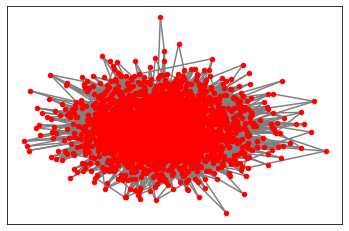

In [45]:
# plot the original network using networkX 

net = nx.from_numpy_array(gold_adjscen_np[:,:3235])
pos = nx.layout.spring_layout(net)

nodes = nx.draw_networkx_nodes(net, pos, node_size=20, node_color='r')
edges = nx.draw_networkx_edges(net, pos, node_size=20, arrowstyle='->',
                               arrowsize=10, edge_color='grey',
                               edge_cmap=plt.cm.Blues, width=1.5)

degs = [d for n,d in net.degree]
print("mean degree in network",np.mean(degs))
print("maximum degree",np.max(degs))
print("minimum degree",np.min(degs))
plt.show()